## Train a cellpose 2D model with different training configurations

We vary 

1.  Starting point (cyto3 or None)
2.  Type of solver Stochastic Gradient Descent or RAdam
3.  Number of epochs
4.  Image per epoch

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
from cellpose import models, io
from pathlib import Path

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [19]:
tnia_images_path = Path(r"D:\images")
parent_path = r'D:\images\tnia-python-images\imagesc\2024_09_29_training_cellpose'

train_path = os.path.join(parent_path, 'patches')

image_patch_path = train_path + '/ground truth0'
label_patch_path = train_path + '/input0'

model_path = os.path.join(parent_path,'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

## Use a helper to collect the training data

The helper will also normalize the inputs.

In [20]:
from tnia.deeplearning.dl_helper import collect_training_data
X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, add_trivial_channel=False, relabel=True)

print('Number of input images', len(X))
print('Number of ground truth images ', len(Y))

print('Size of first input image', X[0].shape)
print('Size of first ground truth image ', Y[0].shape)

Number of input images 400
Number of ground truth images  400
Size of first input image (256, 256, 3)
Size of first ground truth image  (256, 256)


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256, 3) (256, 256)
0.0 1.0


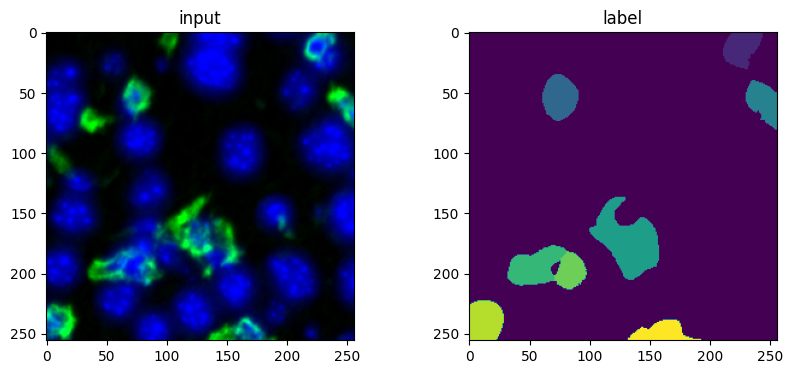

In [21]:

print(X[0].shape, Y[0].shape)
print(X[0].min(), X[0].max())
fig=imshow_multi2d([X[2], Y[2]], ['input', 'label'], 1,2)

## Divide into training and validation sets

Unlike stardist Cellpose does not seem to need numpy arrays as input.  So to create training and validation sets we can simply split the X and Y vectors. 

In [155]:

X_ = X.copy()
Y_ = Y.copy()

# note we don't have a lot of training patches so we will use them for both training and testing (very bad but this is just for proof of concept)

X_train = X_
Y_train = Y_
X_test = X_.copy()
Y_test = Y_.copy()

print('Number of images', len(X_))
print('Number of training images', len(X_train))
print('Number of test images ', len(X_test))



Number of images 400
Number of training images 400
Number of test images  400


In [6]:
X_train[0].shape, Y_train[0].shape

((256, 256, 3), (256, 256))

## Create a dataframe

We use this to keep track of number of objects found for each set of cellpose model parameters. 

In [77]:
import pandas as pd
df = pd.DataFrame(columns=['trainer', 'start', 'epochs', 'nimg_per_epoch', 'number objects found'])

## Create cellpose models with different parameterizations

Run the below set of cells and add the model parameters and number of objects found to the dataframe.  After trying a few variations we can print out the dataframe so we have a table showing how 'number object found' changes based on the 'trainer', 'start' (starting model), number epochs and number images per epoch. 

In [184]:
import os

trainer = 'sgd'
start = 'cyto3'
n_epochs = 400
nimg_per_epoch = 400

model_name = 'cellpose_'+trainer+'_'+start+'_epochs'+str(n_epochs)+'_nimg'+str(nimg_per_epoch)

print(model_name)

# start logger (to see training across epochs)
logger = io.logger_setup()

if start == 'cyto3':
    model_type = 'cyto3'
else:
    model_type = None

# DEFINE CELLPOSE MODEL (without size model)
model= models.CellposeModel(gpu=True, model_type=model_type)#, pretrained_model=os.path.join(model_path,model_name))


cellpose_sgd_cyto3_epochs400_nimg400
creating new log file
2024-10-04 13:05:45,789 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-10-04 13:05:45,790 [INFO] 
cellpose version: 	3.0.9 
platform:       	win32 
python version: 	3.10.14 
torch version:  	2.2.2+cu118
2024-10-04 13:05:45,837 [INFO] >> cyto3 << model set to be used
2024-10-04 13:05:45,840 [INFO] ** TORCH CUDA version installed and working. **
2024-10-04 13:05:45,842 [INFO] >>>> using GPU
2024-10-04 13:05:46,169 [INFO] >>>> loading model C:\Users\bnort\.cellpose\models\cyto3
2024-10-04 13:05:46,281 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


# Train the model

In [185]:
from cellpose import train


im_name = 'RSI_CD_6_A_1_T_0}RGB_B_DAPI_G_f480-1.tiff'
im = io.imread(os.path.join(parent_path, im_name))


In [186]:
help(train.train_seg)

Help on function train_seg in module cellpose.train:

train_seg(net, train_data=None, train_labels=None, train_files=None, train_labels_files=None, train_probs=None, test_data=None, test_labels=None, test_files=None, test_labels_files=None, test_probs=None, load_files=True, batch_size=8, learning_rate=0.005, n_epochs=2000, weight_decay=1e-05, momentum=0.9, SGD=False, channels=None, channel_axis=None, rgb=False, normalize=True, compute_flows=False, save_path=None, save_every=100, nimg_per_epoch=None, nimg_test_per_epoch=None, rescale=True, scale_range=None, bsize=224, min_train_masks=5, model_name=None)
    Train the network with images for segmentation.
    
    Args:
        net (object): The network model to train.
        train_data (List[np.ndarray], optional): List of arrays (2D or 3D) - images for training. Defaults to None.
        train_labels (List[np.ndarray], optional): List of arrays (2D or 3D) - labels for train_data, where 0=no masks; 1,2,...=mask labels. Defaults to None

In [187]:

channel_to_segment = 2
optional_channel = 3

if trainer == 'sgd':
    use_sgd = True
else:
    use_sgd = False

new_model_path = train.train_seg(model.net, X_train, Y_train, 
                              #test_data=X_val,
                              #test_labels=Y_val,
                              channels=[channel_to_segment,optional_channel], 
                              save_path=parent_path, 
                              n_epochs=n_epochs,
                              min_train_masks=0,
                              SGD = use_sgd,
                              learning_rate=.02, 
                              #weight_decay=weight_decay, 
                              rescale = False,  
                              nimg_per_epoch=nimg_per_epoch,
                              model_name=model_name,
                              normalize=False)

2024-10-04 13:05:55,767 [INFO] computing flows for labels


  1%|▏         | 5/400 [00:00<00:28, 13.91it/s]

2024-10-04 13:05:56,353 [WARNING] empty masks!


  2%|▏         | 9/400 [00:00<00:18, 21.00it/s]

2024-10-04 13:05:56,391 [WARNING] empty masks!


 10%|▉         | 38/400 [00:01<00:15, 22.90it/s]

2024-10-04 13:05:57,553 [WARNING] empty masks!


 13%|█▎        | 51/400 [00:02<00:13, 26.58it/s]

2024-10-04 13:05:58,056 [WARNING] empty masks!


 30%|██▉       | 119/400 [00:04<00:09, 28.77it/s]

2024-10-04 13:06:00,702 [WARNING] empty masks!


 36%|███▌      | 144/400 [00:05<00:10, 24.18it/s]

2024-10-04 13:06:01,750 [WARNING] empty masks!
2024-10-04 13:06:01,753 [WARNING] empty masks!


 40%|███▉      | 159/400 [00:06<00:10, 22.76it/s]

2024-10-04 13:06:02,283 [WARNING] empty masks!


 41%|████      | 163/400 [00:06<00:09, 26.13it/s]

2024-10-04 13:06:02,429 [WARNING] empty masks!


 44%|████▍     | 177/400 [00:06<00:07, 29.38it/s]

2024-10-04 13:06:02,880 [WARNING] empty masks!
2024-10-04 13:06:02,883 [WARNING] empty masks!


 46%|████▌     | 182/400 [00:07<00:06, 32.44it/s]

2024-10-04 13:06:03,092 [WARNING] empty masks!


 46%|████▋     | 186/400 [00:07<00:06, 32.19it/s]

2024-10-04 13:06:03,097 [WARNING] empty masks!


 48%|████▊     | 190/400 [00:07<00:07, 29.89it/s]

2024-10-04 13:06:03,403 [WARNING] empty masks!


 72%|███████▏  | 289/400 [00:11<00:04, 24.91it/s]

2024-10-04 13:06:07,341 [WARNING] empty masks!


 77%|███████▋  | 309/400 [00:12<00:03, 27.94it/s]

2024-10-04 13:06:08,166 [WARNING] empty masks!


 80%|███████▉  | 318/400 [00:12<00:03, 23.41it/s]

2024-10-04 13:06:08,472 [WARNING] empty masks!


 87%|████████▋ | 347/400 [00:13<00:02, 23.94it/s]

2024-10-04 13:06:09,731 [WARNING] empty masks!


 95%|█████████▌| 380/400 [00:15<00:00, 26.54it/s]

2024-10-04 13:06:11,065 [WARNING] empty masks!


 96%|█████████▌| 384/400 [00:15<00:00, 27.75it/s]

2024-10-04 13:06:11,163 [WARNING] empty masks!


100%|██████████| 400/400 [00:15<00:00, 25.24it/s]

2024-10-04 13:06:11,742 [INFO] >>> computing diameters



  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bnort\miniconda3\envs\pytorch_and_SAM3\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 400/400 [00:00<00:00, 2988.76it/s]

2024-10-04 13:06:11,882 [INFO] >>> using channels [2, 3]


2024-10-04 13:06:12,112 [INFO] >>> n_epochs=400, n_train=400, n_test=None
2024-10-04 13:06:12,114 [INFO] >>> SGD, learning_rate=0.02000, weight_decay=0.00001, momentum=0.900
2024-10-04 13:06:12,117 [INFO] >>> saving model to D:\images\tnia-python-images\imagesc\2024_09_29_training_cellpose\models\cellpose_sgd_cyto3_epochs400_nimg400
2024-10-04 13:06:17,557 [INFO] 0, train_loss=3.1870, test_loss=0.0000, LR=0.0000, time 5.44s
2024-10-04 13:06:46,272 [INFO] 5, train_loss=0.6786, test_loss=0.0000, LR=0.0111, time 34.16s
2024-10-04 13:07:14,906 [INFO] 10, train_loss=0.4752, test_loss=0.0000, LR=0.0200, time 62.79s
2024-10-04 13:08:11,972 [INFO] 20, train_loss=0.4664, test_loss=0.0000, LR=0.0200, time 119.86s
2024-10-04 13:09:09,665 [INFO] 30, train_loss=0.4419, test_loss=0.0000, LR=0.0200, time 177.55s
2024-10-04 13:10:08,212 [INFO] 40, train_loss=0.4028, test_loss=0.0000, LR=0.0200, time 236.10s
2024-10-04 13:11:05,976 [INFO] 50, train_loss=0.3091, test_loss=0.0000, LR=0.0200, time 293.86s

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

In [188]:
masks = model.eval(im, channels=[channel_to_segment, optional_channel])
num_masks = masks[0].max()

In [189]:
df = pd.concat([df, pd.DataFrame([[trainer, start, n_epochs, nimg_per_epoch, num_masks]], columns=df.columns)], axis=0)

In [191]:
df.head(20)

,trainer,start,epochs,nimg_per_epoch,number objects found
0,sgd,ctyo3,100,1,0
0,sgd,ctyo3,1000,1,70
0,sgd,ctyo3,1,100,0
0,sgd,ctyo3,10000,1,68
0,sgd,ctyo3,100,100,74
0,sgd,ctyo3,400,100,97
0,sgd,none,100,1,0
0,sgd,none,1000,1,64
0,Adam,cyto3,100,1,24
0,Adam,cyto3,1000,1,67


In [183]:
print(df.to_markdown(index=False))

| trainer   | start   |   epochs |   nimg_per_epoch |   number objects found |
|:----------|:--------|---------:|-----------------:|-----------------------:|
| sgd       | ctyo3   |      100 |                1 |                      0 |
| sgd       | ctyo3   |     1000 |                1 |                     70 |
| sgd       | ctyo3   |        1 |              100 |                      0 |
| sgd       | ctyo3   |    10000 |                1 |                     68 |
| sgd       | ctyo3   |      100 |              100 |                     74 |
| sgd       | ctyo3   |      400 |              100 |                     97 |
| sgd       | none    |      100 |                1 |                      0 |
| sgd       | none    |     1000 |                1 |                     64 |
| Adam      | cyto3   |      100 |                1 |                     24 |
| Adam      | cyto3   |     1000 |                1 |                     67 |
| Adam      | cyto3   |    10000 |                1 

In [148]:
csv_name = os.path.join(parent_path, 'training_results.csv')
df.to_csv(csv_name, index=False)

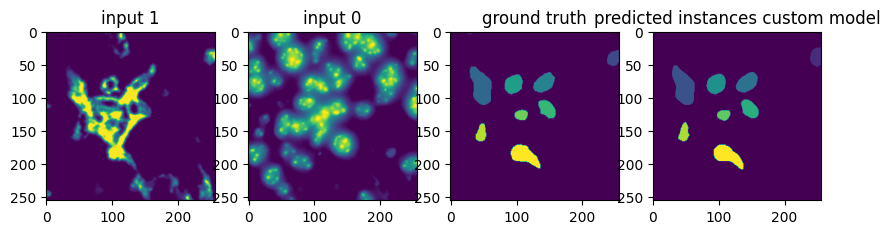

In [15]:

# run model on test images
n=50
masks = model.eval(X_train[n], channels=[channel_to_segment, optional_channel], cellprob_threshold=-1, flow_threshold=0.5, normalize=False)
fig = imshow_multi2d([X_train[n][:,:,channel_to_segment-1], X_train[n][:,:,optional_channel-1], Y_train[n], masks[0]],['input 1','input 0', 'ground truth','predicted instances custom model'],1,4)


## View in Napari

In [192]:
import napari

viewer = napari.Viewer()
viewer.add_image(im, name='testim')
viewer.add_labels(masks[0], name='labels')

<Labels layer 'labels' at 0x2bc3f1371c0>